# Building the CNN to detect Kodak instead of other cats

In [1]:
# Importing important packages
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random
import torch
import cv2
import os

Kodak data files:  26
Not-Kodak data files:  26


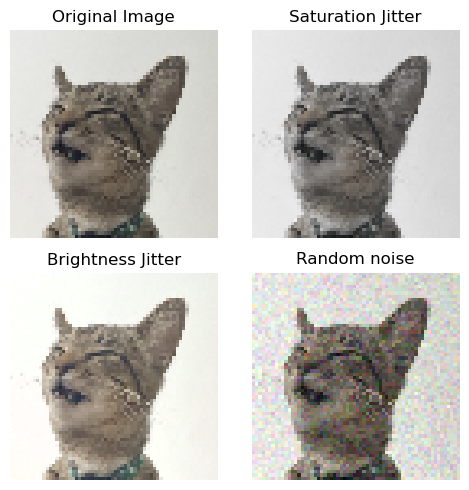

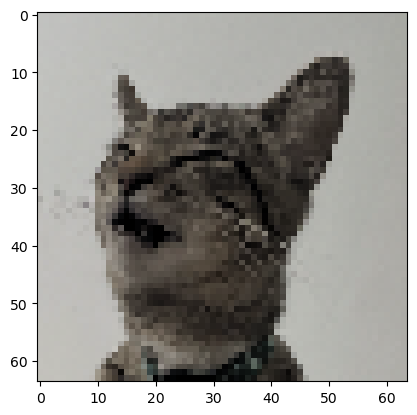

5000
5000


In [2]:
# Magic code to have it run all of the data augmentation file!

%run 'data_processing.ipynb'

# Fine-tuning the ResNet18 Model

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import copy

In [4]:
# Creating our train, valid, test sets using functions defined in the data_processing.ipynb file
X_train, X_val, X_test = split_data(X)
y_train, y_val, y_test = split_data(y)

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [24]:
# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_train_tensor = X_train_tensor.view(-1, 3, 64, 64)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_val_tensor = X_val_tensor.view(-1, 3, 64, 64)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
X_test_tensor = X_test_tensor.view(-1, 3, 64, 64)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)
test_loader = DataLoader(test_dataset, batch_size=4)


In [25]:
class_names = [0, 1]

In [26]:
model = models.resnet18()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [28]:
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [30]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler, train_loader, val_loader, num_epochs = 2)

Epoch 0/1
----------
train Loss: 0.0023 Acc: 0.9997
val Loss: 0.0006 Acc: 1.0000

Epoch 1/1
----------
train Loss: 0.0009 Acc: 1.0000
val Loss: 0.0003 Acc: 1.0000

Best val Acc: 1.000000


Model works so well to identify Kodak!! Great news!

Now that we have a model that can identify the little shit bag, we can move on to writing code that look for him in a video stream.